In [1]:
import numpy as np
import sklearn as skl
import skmultiflow as smf  # pip install scikit-multiflow
from matplotlib import pyplot as plt

from lasvm import LaSVM, KernelPerceptron, BudgetKernelPerceptron

plt.style.use('seaborn-whitegrid')

In [2]:
breast_cancer = skl.datasets.load_breast_cancer()

x = breast_cancer['data']
y = breast_cancer['target']

x.shape, y.shape

((569, 30), (569,))

In [3]:
x_train, x_test, y_train, y_test = skl.model_selection.train_test_split(
                                                x, y, test_size=0.2, shuffle=True)

x_train.shape, x_test.shape

((455, 30), (114, 30))

### (Offline) SVC

In [4]:
svc = skl.svm.SVC().fit(x_train, y_train)

print('accuracy:', svc.score(x_test, y_test))

accuracy: 0.9122807017543859


### LaSVM

In [5]:
pos_samples = x_train[y_train == 1][:3]
neg_samples = x_train[y_train == 0][:3]

lasvm = LaSVM(pos_samples, neg_samples).fit(x_train, y_train)

print('accuracy:', lasvm.score(x_test, y_test))

accuracy: 0.9210526315789473


### Kernel Perceptron

In [6]:
kp = KernelPerceptron().fit(x_train, y_train)

print('accuracy:', kp.score(x_test, y_test))

accuracy: 0.8859649122807017


### Budget Kernel Perceptron

In [7]:
bkp = BudgetKernelPerceptron(n=30).fit(x_train, y_train)

print('accuracy:', bkp.score(x_test, y_test))

accuracy: 0.8333333333333334


## Streaming scenario

In [8]:
def cummean(l: list) -> np.ndarray:
    l = np.cumsum(l)
    l /= np.arange(1, l.size + 1)
    
    return l

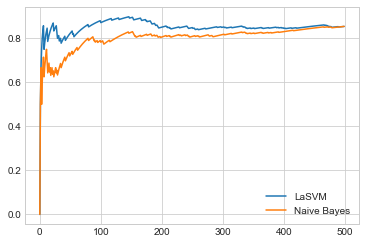

In [9]:
stream = smf.data.HyperplaneGenerator()

nb = smf.bayes.NaiveBayes()

x, y = stream.next_sample(batch_size=10)
pos_samples = x[y == 1][:3]
neg_samples = x[y == 0][:3]
lasvm = LaSVM(pos_samples, neg_samples)

nb_score = []
lasvm_score = []

for _ in range(500):
    x, y = stream.next_sample()
    nb_score.append(nb.score(x, y))
    lasvm_score.append(lasvm.score(x, y))
    
    nb.partial_fit(x, y)
    lasvm.partial_fit(x, y)
    
nb_score = cummean(nb_score)
lasvm_score = cummean(lasvm_score)

plt.plot(lasvm_score, label='LaSVM')
plt.plot(nb_score, label='Naive Bayes')

plt.legend()
plt.show()